# Uproot

In [2]:
import uproot as ur
import numpy as np
import awkward as ak
import hist 
import matplotlib.pyplot as plt
import IPython
import matplotlib.pylab as plb

In [3]:
import ROOT

Welcome to JupyROOT 6.28/04


## General

### Short example using uproot

In [4]:
upfile = ur.open('data/ZZTo4e.root')
uptree = upfile['Events']
uptree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

- uint32_t is unsigned 
- i4 is 4bit integer 
- etc etc 

The general strategy is to get arrays in one function call (usually slow, has to read) and use them interactively afterward.

In [5]:
elec = uptree.arrays([ 'nElectron', 'Electron_pt', 'Electron_eta', 'Electron_phi', 'Electron_charge' ], cut="nElectron >= 2", how="zip", entry_stop=1000000)
elec

<Array [{nElectron: 3, Electron: [, ... ] type='638197 * {"nElectron": uint32, "...'>

In [6]:
elec[0]

<Record ... phi: 1.15, charge: 1}]} type='{"nElectron": uint32, "Electron": var ...'>

In [7]:
elec[1]

<Record ... phi: 2.25, charge: -1}]} type='{"nElectron": uint32, "Electron": var...'>

In [8]:
elec[0]["Electron"]

<Array [{pt: 11.9, eta: 0.335, ... charge: 1}] type='3 * {"pt": float32, "eta": ...'>

In [9]:
elec[0]["Electron"].fields

['pt', 'eta', 'phi', 'charge']

In [10]:
 elec[0]["Electron"]["pt"] 

<Array [11.9, 26.7, 40.2] type='3 * float32'>

Data is stored here in a jagged structure

In [11]:
#for example
elec[2:10]["Electron"]["pt"]

<Array [[7.92, 15.6], ... 92.3, 80.7, 13.9]] type='8 * var * float32'>

- Here type = '8 \* var \* float32'
- 8 events
- var is variable which conveys that these pt values correspond to different number of electrons
- float32 represents the type of data element stored

In [12]:
elec[50]["Electron"]["pt"][0]

44.61445617675781

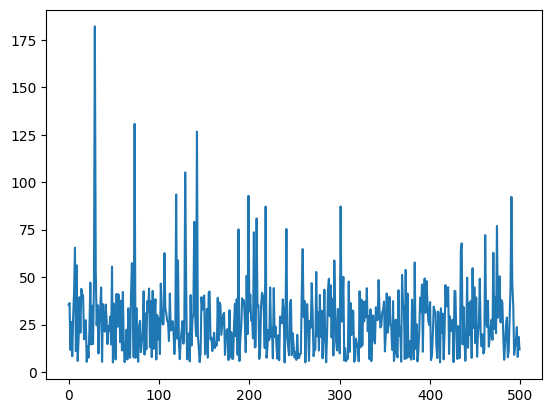

In [13]:
pts = np.array([])
for i in range(500) :
    pts = np.append(elec[i]["Electron"]["pt"][0], pts )
plt.plot(pts)
plt.show()

In [14]:
#making more cuts
cuts = elec[:, 'Electron', 'charge', 0] != elec[:,'Electron','charge',1]
cuts

<Array [False, True, True, ... True, True] type='638197 * bool'>

In [15]:
#slicing to obtain the two muons
elec1 = elec["Electron", cuts, 0]
elec2 = elec["Electron", cuts, 1]

In [16]:
elec1

<Array [{pt: 18.5, eta: 0.847, ... charge: 1}] type='434143 * {"pt": float32, "e...'>

In [17]:
elec2

<Array [{pt: 14.8, eta: 1.02, ... charge: -1}] type='434143 * {"pt": float32, "e...'>

In [18]:
#create a histogram
h1 = hist.Hist.new.Reg(120, 0, 120, name="Mass").Double()
#h1 = hist.Hist.new.Reg(120'''bins''', 0'''start''', 120'''end''', name="Mass").Double()


In [19]:
h1.fill(np.sqrt(2*elec1.pt*elec2.pt*(np.cosh(elec1.eta - elec2.eta) - np.cos(elec1.phi - elec2.phi))))

Hist(Regular(120, 0, 120, name='Mass'), storage=Double()) # Sum: 422837.0 (434143.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f53a7552230>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

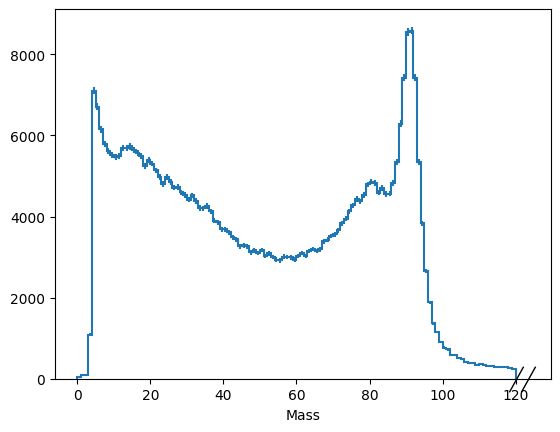

In [20]:
#plot in matplotlib
h1.plot()

### Short example using pyROOT 

In [21]:
rootfile = ROOT.TFile.Open("data/ZZTo4e.root")
tree = rootfile.Get("Events")

In [22]:
h2 = ROOT.TH1D("h2", "Mass" , 120,0,120)

for i, event in enumerate(tree):
    if i == 100000 :
        break
    if event.nElectron >= 2 and event.Electron_charge[0] != event.Electron_charge :
        elec1_pt = event.Electron_pt[0]
        elec2_pt = event.Electron_pt[1]
        elec1_eta = event.Electron_eta[0]
        elec2_eta = event.Electron_eta[1]
        elec1_phi = event.Electron_phi[0]
        elec2_phi = event.Electron_phi[1]
        h2.Fill(np.sqrt(2*elec1_pt*elec2_pt*(np.cosh(elec1_eta - elec2_eta) - np.cos(elec1_phi - elec2_phi))))

In [23]:
%jsroot
c1 = ROOT.TCanvas()
h2.Draw()
c1.Draw()

### Short example using RDataFrame :
- It is called a 'lazy' approach. This means that the triggering of the event loop happens only when we draw a histogram or plot something

In [24]:
df = ROOT.RDataFrame("Events", "data/ZZTo4e.root")
c1 = ROOT.TCanvas()

In [25]:
print(df)

A data frame built on top of the Events dataset.


In [26]:
df_limit = df.Range(100000)

In [27]:
df_cuts1 = df.Filter("nElectron >= 2 ")
df_cuts2 = df.Filter("Electron_charge[0]  != Electron_charge[1]")

In [28]:
#Assign the computation to C++ Root JIT
df_mass = df_cuts2.Define("DiElectron_mass", '''
float elec1_pt = Electron_pt[0];
float elec2_pt = Electron_pt[1];
float elec1_eta = Electron_eta[0];
float elec2_eta = Electron_eta[1];
float elec1_phi = Electron_phi[0];
float elec2_phi = Electron_phi[1];
return sqrt(2*elec1_pt*elec2_pt*(cosh(elec1_eta - elec2_eta) - cos(elec1_phi - elec2_phi)));
''')
h3= df_mass.Histo1D(("h3", "mass", 120, 0, 120), "DiElectron_mass")

In [29]:
%jsroot
h3.Draw()   # <--- This is the line that computes everything.
c1.Draw()

In [30]:
for x in df.GetColumnNames():
    print(x)

Electron_charge
Electron_dxy
Electron_dxyErr
Electron_dz
Electron_dzErr
Electron_eta
Electron_mass
Electron_pfRelIso03_all
Electron_phi
Electron_pt
MET_phi
MET_pt
Muon_charge
Muon_dxy
Muon_dxyErr
Muon_dz
Muon_dzErr
Muon_eta
Muon_mass
Muon_pfRelIso03_all
Muon_pfRelIso04_all
Muon_phi
Muon_pt
PV_npvs
PV_x
PV_y
PV_z
event
luminosityBlock
nElectron
nMuon
run


In [31]:
for x in df_mass.GetColumnNames():
    print(x)

DiElectron_mass
Electron_charge
Electron_dxy
Electron_dxyErr
Electron_dz
Electron_dzErr
Electron_eta
Electron_mass
Electron_pfRelIso03_all
Electron_phi
Electron_pt
MET_phi
MET_pt
Muon_charge
Muon_dxy
Muon_dxyErr
Muon_dz
Muon_dzErr
Muon_eta
Muon_mass
Muon_pfRelIso03_all
Muon_pfRelIso04_all
Muon_phi
Muon_pt
PV_npvs
PV_x
PV_y
PV_z
event
luminosityBlock
nElectron
nMuon
run


In [32]:
for x in df_mass.GetDefinedColumnNames():
    print(x)

DiElectron_mass


## Uproot Operations

### Navigating TDirectories

In [33]:
directory = ur.open("2022-08-01-uproot-awkward-columnar-hats/data/nesteddirs.root") #imports as a TDirectory object
directory

<ReadOnlyDirectory '/' at 0x7f538143e620>

In [34]:
file = directory.file #access the file
file

<ReadOnlyFile '2022-08-01-uproot-awkward-columnar-hats/data/nesteddirs.root' at 0x7f538145cc10>

In [35]:
file.file_path

'2022-08-01-uproot-awkward-columnar-hats/data/nesteddirs.root'

In [36]:
file.root_version #the root version with which the file was created?

'6.08/04'

In [37]:
file.uuid #unique id of the file

UUID('ac63575a-9ca4-11e7-9607-0100007fbeef')

In [38]:
dir(file)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_array_cache',
 '_begin_chunk',
 '_custom_classes',
 '_decompression_executor',
 '_fBEGIN',
 '_fCompress',
 '_fEND',
 '_fNbytesFree',
 '_fNbytesInfo',
 '_fNbytesName',
 '_fSeekFree',
 '_fSeekInfo',
 '_fUUID',
 '_fUUID_version',
 '_fUnits',
 '_fVersion',
 '_file_path',
 '_interpretation_executor',
 '_nfree',
 '_object_cache',
 '_options',
 '_source',
 '_streamer_rules',
 '_streamers',
 'array_cache',
 'begin_chunk',
 'chunk',
 'class_named',
 'close',
 'closed',
 'compression',
 'custom_classes',
 'decompression_executor',
 'detached',
 'fBEGIN',
 'fCompress',
 'fEND',
 'fNbytesFree',
 'fNbytesI

TDirectory acts like a python dictionary(or mapping or hashmap) and hence has items, keys and value

In [39]:
?directory.keys

Signature:
directory.keys(
    recursive=True,
    cycle=True,
    filter_name=<function no_filter at 0x7f540edf49d0>,
    filter_classname=<function no_filter at 0x7f540edf49d0>,
)
Docstring:
Args:
    recursive (bool): If True, descend into any nested subdirectories.
        If False, only return the names of objects directly accessible
        in this ``TDirectory``.
    cycle (bool): If True, include the cycle numbers in those names.
    filter_name (None, glob string, regex string in ``"/pattern/i"`` syntax, function of str → bool, or iterable of the above): A
        filter to select keys by name.
    filter_classname (None, glob string, regex string in ``"/pattern/i"`` syntax, function of str → bool, or iterable of the above): A
        filter to select keys by C++ (decoded) classname.

Returns the names of the objects in this ``TDirectory`` as a list of
strings.

Note that this does not read any data from the file.
File:      ~/.local/lib/python3.10/site-packages/uproot/reading

In [40]:
directory.keys()

['one;1',
 'one/two;1',
 'one/two/tree;1',
 'one/tree;1',
 'three;1',
 'three/tree;1']

these 1s represent the iterative cycle numbers

In [41]:
directory.keys(cycle = False) #to suppress the cycle number

['one', 'one/two', 'one/two/tree', 'one/tree', 'three', 'three/tree']

In [42]:
directory["one"]

<ReadOnlyDirectory '/one' at 0x7f538145e470>

In [43]:
directory["one/two"]

<ReadOnlyDirectory '/one/two' at 0x7f538145e1a0>

In [44]:
directory["one/tree"]

<TTree 'tree' (3 branches) at 0x7f538145efe0>

In [45]:
directory["one/two/tree"]

<TTree 'tree' (20 branches) at 0x7f5381480d60>

In [46]:
directory["one"]["two"]["tree"] #same as before

<TTree 'tree' (20 branches) at 0x7f5381480d60>

In [47]:
directory["one/two/tree"] == directory["one"]["two"]["tree"]

True

In [48]:
directory.values()

[<ReadOnlyDirectory '/one' at 0x7f538145e470>,
 <ReadOnlyDirectory '/one/two' at 0x7f538145e1a0>,
 <TTree 'tree' (20 branches) at 0x7f5381480d60>,
 <TTree 'tree' (3 branches) at 0x7f538145efe0>,
 <ReadOnlyDirectory '/three' at 0x7f538145e0b0>,
 <TTree 'tree' (1 branches) at 0x7f538145cd60>]

In [49]:
directory.values(recursive = False) #prevents it from recursively looking into folders

[<ReadOnlyDirectory '/one' at 0x7f538145e470>,
 <ReadOnlyDirectory '/three' at 0x7f538145e0b0>]

In [50]:
directory.items() #creates tuple iterables (key,value)

[('one;1', <ReadOnlyDirectory '/one' at 0x7f538145e470>),
 ('one/two;1', <ReadOnlyDirectory '/one/two' at 0x7f538145e1a0>),
 ('one/two/tree;1', <TTree 'tree' (20 branches) at 0x7f5381480d60>),
 ('one/tree;1', <TTree 'tree' (3 branches) at 0x7f538145efe0>),
 ('three;1', <ReadOnlyDirectory '/three' at 0x7f538145e0b0>),
 ('three/tree;1', <TTree 'tree' (1 branches) at 0x7f538145cd60>)]

In [51]:
directory.items(recursive = False)

[('one;1', <ReadOnlyDirectory '/one' at 0x7f538145e470>),
 ('three;1', <ReadOnlyDirectory '/three' at 0x7f538145e0b0>)]

In [52]:
directory.classnames()

{'one;1': 'TDirectory',
 'one/two;1': 'TDirectory',
 'one/two/tree;1': 'TTree',
 'one/tree;1': 'TTree',
 'three;1': 'TDirectory',
 'three/tree;1': 'TTree'}

In [53]:
directory.classnames(recursive = False)

{'one;1': 'TDirectory', 'three;1': 'TDirectory'}

In [54]:
directory.keys(filter_classname= "TTree")

['one/two/tree;1', 'one/tree;1', 'three/tree;1']

In [55]:
directory.keys(filter_classname= "TT*")

['one/two/tree;1', 'one/tree;1', 'three/tree;1']

In [56]:
directory.keys(filter_classname= "/TTree*/")

['one/two/tree;1', 'one/tree;1', 'three/tree;1']

### Generic Objects

- Uproot does not have specialized code to recognize all the ROOT Objects.
- TStreamerInfo by root helps tho
- TStreamerInfo is an object creator i guess

In [57]:
import ROOT as rt

In [58]:
directory = ur.open("2022-08-01-uproot-awkward-columnar-hats/data/icecube-supernovae.root")
directory.classnames(cycle=False)

{'config': 'TDirectory',
 'config/analysis': 'SN_Analysis_Configuration_t',
 'config/detector': 'I3Eval_t',
 'config/run': 'SN_File_t',
 'sn_all': 'TTree',
 'sn_gps': 'TTree',
 'sn_range': 'TTree',
 'sn_o2rout': 'TTree',
 'sn_o2cand': 'TTree',
 'sn_omwatch': 'TTree',
 'sn_sigsim': 'TTree'}

The classes `SN_Analysis_Configuration_t`, `I3Eval_t`, `SN_File_t` were generated from the [TStreamerInfo](https://uproot.readthedocs.io/en/latest/uproot.streamers.Model_TStreamerInfo.html).

In [59]:
directory.streamer_of("config")

In [60]:
directory.streamer_of("config/detector")

<TStreamerInfo for I3Eval_t version 7 at 0x7f5380991210>

In [61]:
directory.file.show_streamers("I3Eval_t")

I3Eval_t::ChannelContainer_t (v1)

Sni3DataArray (v1)

TObject (v1)
    fUniqueID: unsigned int (TStreamerBasicType)
    fBits: unsigned int (TStreamerBasicType)

I3Eval_t (v7): TObject (v1)
    theDataArray: Sni3DataArray* (TStreamerObjectAnyPointer)
    NumberOfChannels: int (TStreamerBasicType)
    NoAvailableSlices: int (TStreamerBasicType)
    AvailableDataSize: int (TStreamerBasicType)
    mGPSCardId: int (TStreamerBasicType)
    mGPSPrescale: int (TStreamerBasicType)
    mGPSEventNo: int (TStreamerBasicType)
    mScalerCardId: int (TStreamerBasicType)
    mScalerStartChannel: int (TStreamerBasicType)
    StartUTC: long (TStreamerBasicType)
    MaxChannels: int (TStreamerBasicType)
    mMaxJitterLogs: int (TStreamerBasicType)
    Channel: I3Eval_t::ChannelContainer_t* (TStreamerObjectAnyPointer)
    ChannelIDMap: map<long,int> (TStreamerSTL)
    BadChannelIDSet: set<long> (TStreamerSTL)
    ChannelID: long* (TStreamerBasicPointer)
    Deadtime: double* (TStreamerBasicPointer)
   

I3Eval\_t inherits from the TObject

In [62]:
directory["config/detector"] #gives back that TStreamer object

<I3Eval_t (version 7) at 0x7f5380d20460>

In [63]:
directory.streamer_of("config/detector").all_members

{'@fUniqueID': 0,
 '@fBits': 50397184,
 'fName': 'I3Eval_t',
 'fTitle': '',
 'fCheckSum': 4126722793,
 'fClassVersion': 7,
 'fElements': <TObjArray of 19 items at 0x7f53809a40a0>}

Getting the methods and members of TStreamer object is a bit more verbose than the normal

In [64]:
directory.streamer_of("config/detector").member("fElements") #use the member method to access the defined attributes and methods

<TObjArray of 19 items at 0x7f53809a40a0>

In [65]:
directory.streamer_of("config/detector").member("fClassVersion")

7

- member seems to be a dictionary with keys as name of attributes which could be accessed by all_members method
- values are the actual function and data objects stored

In [66]:
directory["config/detector"].member("Deadtime") #access the variables of the object

array([250., 250., 250., ..., 250., 250., 250.])

### Histograms and Graph

Normally, you'd convert

   * [to_numpy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#to-numpy): tuple of arrays (values and edges)
   * [to_boost](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#to-boost): `boost_histogram` object
   * [to_hist](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#to-hist): `hist` object (more fully featured subclass of `boost_histogram`)

In [67]:
directory = ur.open("2022-08-01-uproot-awkward-columnar-hats/data/hepdata-example.root")
directory.classnames(cycle = False)

{'hpx': 'TH1F', 'hpxpy': 'TH2F', 'hprof': 'TProfile', 'ntuple': 'TNtuple'}

In [68]:
directory["hpx"]

<TH1F (version 1) at 0x7f5380917f10>

In [69]:
hist1 = directory["hpx"].to_numpy()
hist1

(array([2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 1.200e+01, 8.000e+00, 9.000e+00, 1.500e+01, 1.500e+01,
        3.100e+01, 3.500e+01, 4.000e+01, 6.400e+01, 6.400e+01, 8.100e+01,
        1.080e+02, 1.240e+02, 1.560e+02, 1.650e+02, 2.090e+02, 2.620e+02,
        2.970e+02, 3.920e+02, 4.320e+02, 4.660e+02, 5.210e+02, 6.040e+02,
        6.570e+02, 7.880e+02, 9.030e+02, 1.079e+03, 1.135e+03, 1.160e+03,
        1.383e+03, 1.458e+03, 1.612e+03, 1.770e+03, 1.868e+03, 1.861e+03,
        1.946e+03, 2.114e+03, 2.175e+03, 2.207e+03, 2.273e+03, 2.276e+03,
        2.329e+03, 2.325e+03, 2.381e+03, 2.417e+03, 2.364e+03, 2.284e+03,
        2.188e+03, 2.164e+03, 2.130e+03, 1.940e+03, 1.859e+03, 1.763e+03,
        1.700e+03, 1.611e+03, 1.459e+03, 1.390e+03, 1.237e+03, 1.083e+03,
        1.046e+03, 8.880e+02, 7.520e+02, 7.420e+02, 6.730e+02, 5.550e+02,
        5.330e+02, 3.660e+02, 3.780e+02, 2.720e+02, 2.560e+02, 2.000e+02,
        1.740e+02, 1.320e+02, 1.180e+0

[2.000e+00 3.000e+00 1.000e+00 1.000e+00 2.000e+00 4.000e+00 6.000e+00
 1.200e+01 8.000e+00 9.000e+00 1.500e+01 1.500e+01 3.100e+01 3.500e+01
 4.000e+01 6.400e+01 6.400e+01 8.100e+01 1.080e+02 1.240e+02 1.560e+02
 1.650e+02 2.090e+02 2.620e+02 2.970e+02 3.920e+02 4.320e+02 4.660e+02
 5.210e+02 6.040e+02 6.570e+02 7.880e+02 9.030e+02 1.079e+03 1.135e+03
 1.160e+03 1.383e+03 1.458e+03 1.612e+03 1.770e+03 1.868e+03 1.861e+03
 1.946e+03 2.114e+03 2.175e+03 2.207e+03 2.273e+03 2.276e+03 2.329e+03
 2.325e+03 2.381e+03 2.417e+03 2.364e+03 2.284e+03 2.188e+03 2.164e+03
 2.130e+03 1.940e+03 1.859e+03 1.763e+03 1.700e+03 1.611e+03 1.459e+03
 1.390e+03 1.237e+03 1.083e+03 1.046e+03 8.880e+02 7.520e+02 7.420e+02
 6.730e+02 5.550e+02 5.330e+02 3.660e+02 3.780e+02 2.720e+02 2.560e+02
 2.000e+02 1.740e+02 1.320e+02 1.180e+02 1.000e+02 8.900e+01 8.600e+01
 3.900e+01 3.700e+01 2.500e+01 2.300e+01 2.000e+01 1.600e+01 1.400e+01
 9.000e+00 1.300e+01 8.000e+00 2.000e+00 2.000e+00 6.000e+00 1.000e+00
 0.000

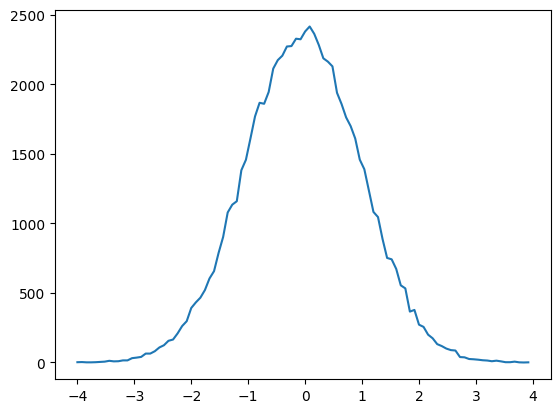

In [70]:
a, b = hist1
print(a)
print(b)
plt.plot(b[:-1],a)

In [71]:
hist2 = directory["hpx"].to_hist()
hist2

Hist(Regular(100, -4, 4, name='xaxis'), storage=Double()) # Sum: 74994.0 (75000.0 with flow)

In [72]:
hist3 = directory["hpxpy"].to_hist()
hist3

Hist(
  Regular(40, -4, 4, name='xaxis'),
  Regular(40, -4, 4, name='yaxis'),
  storage=Double()) # Sum: 74985.0 (75000.0 with flow)

In [73]:
hist4 = directory["hprof"].to_hist()
hist4

Hist(Regular(100, -4, 4, name='xaxis'), storage=WeightedMean()) # Sum: WeightedMean(sum_of_weights=74993, sum_of_weights_squared=74993, value=2.00684, variance=1.97228) (WeightedMean(sum_of_weights=74998, sum_of_weights_squared=74998, value=2.0079, variance=1.989) with flow)

In [74]:
hist5 = directory["hprof"].to_boost()
hist5

Histogram(Regular(100, -4, 4), storage=WeightedMean()) # Sum: WeightedMean(sum_of_weights=74993, sum_of_weights_squared=74993, value=2.00684, variance=1.97228) (WeightedMean(sum_of_weights=74998, sum_of_weights_squared=74998, value=2.0079, variance=1.989) with flow)

### TTrees : General

In [75]:
directory = ur.open("2022-08-01-uproot-awkward-columnar-hats/data/Zmumu.root")
directory.classnames(cycle= False)

{'events': 'TTree'}

In [76]:
uptree = directory["events"]
uptree

<TTree 'events' (20 branches) at 0x7f5380946800>

In [77]:
uptree.keys()

['Type',
 'Run',
 'Event',
 'E1',
 'px1',
 'py1',
 'pz1',
 'pt1',
 'eta1',
 'phi1',
 'Q1',
 'E2',
 'px2',
 'py2',
 'pz2',
 'pt2',
 'eta2',
 'phi2',
 'Q2',
 'M']

In [78]:
uptree.values()

[<TBranch 'Type' at 0x7f53806b77c0>,
 <TBranch 'Run' at 0x7f53806b43d0>,
 <TBranch 'Event' at 0x7f53806b6290>,
 <TBranch 'E1' at 0x7f53806b5b70>,
 <TBranch 'px1' at 0x7f538059fa60>,
 <TBranch 'py1' at 0x7f538059c040>,
 <TBranch 'pz1' at 0x7f538059ca00>,
 <TBranch 'pt1' at 0x7f538059d120>,
 <TBranch 'eta1' at 0x7f538059d840>,
 <TBranch 'phi1' at 0x7f538059df60>,
 <TBranch 'Q1' at 0x7f538059e680>,
 <TBranch 'E2' at 0x7f538059eda0>,
 <TBranch 'px2' at 0x7f538059f7f0>,
 <TBranch 'py2' at 0x7f53806c2a40>,
 <TBranch 'pz2' at 0x7f53806c0340>,
 <TBranch 'pt2' at 0x7f53806c3010>,
 <TBranch 'eta2' at 0x7f53806c3700>,
 <TBranch 'phi2' at 0x7f53806c3e50>,
 <TBranch 'Q2' at 0x7f53806c24a0>,
 <TBranch 'M' at 0x7f53806c1d80>]

In [79]:
uptree["px1"]

<TBranch 'px1' at 0x7f538059fa60>

In [80]:
uptree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Type                 | char*                    | AsStrings()
Run                  | int32_t                  | AsDtype('>i4')
Event                | int32_t                  | AsDtype('>i4')
E1                   | double                   | AsDtype('>f8')
px1                  | double                   | AsDtype('>f8')
py1                  | double                   | AsDtype('>f8')
pz1                  | double                   | AsDtype('>f8')
pt1                  | double                   | AsDtype('>f8')
eta1                 | double                   | AsDtype('>f8')
phi1                 | double                   | AsDtype('>f8')
Q1                   | int32_t                  | AsDtype('>i4')
E2                   | double                   | AsDtype('>f8')
px2                  | double                   | AsDtype('>f

In [81]:
uptree.num_bytes

10011

In [82]:
uptree.typenames()

{'Type': 'char*',
 'Run': 'int32_t',
 'Event': 'int32_t',
 'E1': 'double',
 'px1': 'double',
 'py1': 'double',
 'pz1': 'double',
 'pt1': 'double',
 'eta1': 'double',
 'phi1': 'double',
 'Q1': 'int32_t',
 'E2': 'double',
 'px2': 'double',
 'py2': 'double',
 'pz2': 'double',
 'pt2': 'double',
 'eta2': 'double',
 'phi2': 'double',
 'Q2': 'int32_t',
 'M': 'double'}

In [83]:
{key : value.interpretation for key , value in uptree.items()}

{'Type': AsStrings(),
 'Run': AsDtype('>i4'),
 'Event': AsDtype('>i4'),
 'E1': AsDtype('>f8'),
 'px1': AsDtype('>f8'),
 'py1': AsDtype('>f8'),
 'pz1': AsDtype('>f8'),
 'pt1': AsDtype('>f8'),
 'eta1': AsDtype('>f8'),
 'phi1': AsDtype('>f8'),
 'Q1': AsDtype('>i4'),
 'E2': AsDtype('>f8'),
 'px2': AsDtype('>f8'),
 'py2': AsDtype('>f8'),
 'pz2': AsDtype('>f8'),
 'pt2': AsDtype('>f8'),
 'eta2': AsDtype('>f8'),
 'phi2': AsDtype('>f8'),
 'Q2': AsDtype('>i4'),
 'M': AsDtype('>f8')}

### TTrees : Get one array from one TBranch

In [84]:
uptree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Type                 | char*                    | AsStrings()
Run                  | int32_t                  | AsDtype('>i4')
Event                | int32_t                  | AsDtype('>i4')
E1                   | double                   | AsDtype('>f8')
px1                  | double                   | AsDtype('>f8')
py1                  | double                   | AsDtype('>f8')
pz1                  | double                   | AsDtype('>f8')
pt1                  | double                   | AsDtype('>f8')
eta1                 | double                   | AsDtype('>f8')
phi1                 | double                   | AsDtype('>f8')
Q1                   | int32_t                  | AsDtype('>i4')
E2                   | double                   | AsDtype('>f8')
px2                  | double                   | AsDtype('>f

In [85]:
A = uptree["M"]
print(type(A))
print(A)
print("Size(in bytes): ", A.num_bytes)

<class 'uproot.models.TBranch.Model_TBranch_v12'>
<TBranch 'M' at 0x7f53806c1d80>
Size(in bytes):  467


In [86]:
a = uptree["M"].array()
print(type(a))
print(a)
print("length : ",len(a))

<class 'awkward.highlevel.Array'>
[82.5, 83.6, 83.3, 82.1, 90.5, 89.8, 89.8, ... 60.1, 60, 60, 96.1, 96, 96.5, 96.7]
length :  2304


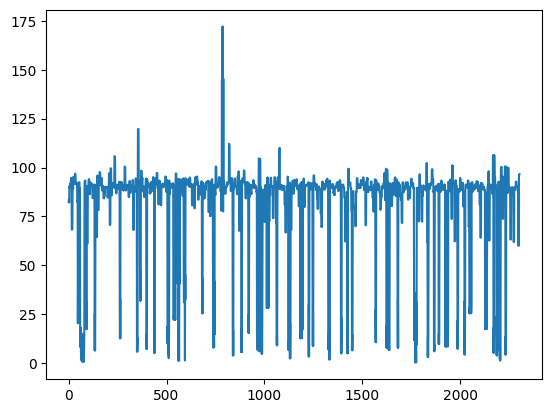

In [87]:
plt.plot(a) # this shows this is indeed an awkward array

In [88]:
a = uptree["M"].array(entry_stop=5)
a

<Array [82.5, 83.6, 83.3, 82.1, 90.5] type='5 * float64'>

Can turn into numpy and pandas arrays

In [89]:
n = uptree["M"].array(library="np") # convert to default
n

array([82.46269156, 83.62620401, 83.30846467, ..., 95.96547966,
       96.49594381, 96.65672765])

In [90]:
type(n)

numpy.ndarray

In [91]:
a = uptree["M"].array(library="ak") # awkward array is the default
a

<Array [82.5, 83.6, 83.3, ... 96, 96.5, 96.7] type='2304 * float64'>

In [92]:
type(a)

awkward.highlevel.Array

In [93]:
p = uptree["M"].array(library="pd") #convert to pandas series
p

0       82.462692
1       83.626204
2       83.308465
3       82.149373
4       90.469123
          ...    
2299    60.047138
2300    96.125376
2301    95.965480
2302    96.495944
2303    96.656728
Length: 2304, dtype: float64

In [94]:
type(p)

pandas.core.series.Series

### Get several TBranches as one array/array group

``` Note : For taking multiples inputs, arrays method is used not array ! ```

In [95]:
uptree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Type                 | char*                    | AsStrings()
Run                  | int32_t                  | AsDtype('>i4')
Event                | int32_t                  | AsDtype('>i4')
E1                   | double                   | AsDtype('>f8')
px1                  | double                   | AsDtype('>f8')
py1                  | double                   | AsDtype('>f8')
pz1                  | double                   | AsDtype('>f8')
pt1                  | double                   | AsDtype('>f8')
eta1                 | double                   | AsDtype('>f8')
phi1                 | double                   | AsDtype('>f8')
Q1                   | int32_t                  | AsDtype('>i4')
E2                   | double                   | AsDtype('>f8')
px2                  | double                   | AsDtype('>f

In [96]:
mu1 = uptree.arrays() # by default an awkward record type
mu1

<Array [{Type: 'GT', Run: 148031, ... M: 96.7}] type='2304 * {"Type": string, "R...'>

In [97]:
type(mu1)

awkward.highlevel.Array

In [98]:
mu1.fields

['Type',
 'Run',
 'Event',
 'E1',
 'px1',
 'py1',
 'pz1',
 'pt1',
 'eta1',
 'phi1',
 'Q1',
 'E2',
 'px2',
 'py2',
 'pz2',
 'pt2',
 'eta2',
 'phi2',
 'Q2',
 'M']

In [99]:
#Can also be specific
mu1 = uptree.arrays(["E1","px1","py1","pz1","eta1","phi1","Q1"])
mu1.fields

['E1', 'px1', 'py1', 'pz1', 'eta1', 'phi1', 'Q1']

In [100]:
mu1 = uptree.arrays(["E1","px1","py1","pz1","eta1","phi1","Q1"],library = "numpy") #loads as a dictionary
mu1

{'E1': array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]),
 'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 'eta1': array([-1.21769, -1.05139, -1.05139, ..., -1.57044, -1.57044, -1.57044]),
 'phi1': array([ 2.74126  , -0.440873 , -0.440873 , ...,  0.0370275,  0.0370275,
         0.0370275]),
 'Q1': array([ 1, -1, -1, ...,  1,  1,  1], dtype=int32)}

In [101]:
mu1 = uptree.arrays(["E1","px1","py1","pz1","eta1","phi1","Q1"], library = "pandas") #loads as d pandas dataframe
mu1

,E1,px1,py1,pz1,eta1,phi1,Q1
0,82.201866,-41.195288,17.433244,-68.964962,-1.217690,2.741260,1
1,62.344929,35.118050,-16.570362,-48.775247,-1.051390,-0.440873,-1
2,62.344929,35.118050,-16.570362,-48.775247,-1.051390,-0.440873,-1
3,60.621875,34.144437,-16.119525,-47.426984,-1.051390,-0.440873,-1
4,41.826389,22.783582,15.036444,-31.689894,-0.990688,0.583351,1
...,...,...,...,...,...,...,...
2299,32.701650,19.054651,14.833954,22.051323,0.818806,0.661492,1
2300,168.780121,-68.041915,-26.105847,-152.235018,-1.482700,-2.775240,-1
2301,81.270136,32.377492,1.199406,-74.532431,-1.570440,0.037027,1
2302,81.270136,32.377492,1.199406,-74.532431,-1.570440,0.037027,1


In [102]:
# computed columns
uptree.arrays(["sqrt(px1**2 + py1**2)", "sqrt(px2**2 + py2**2)"], library="pd")

,sqrt(px1**2 + py1**2),sqrt(px2**2 + py2**2)
0,44.7322,37.7582
1,38.8311,44.7322
2,38.8311,44.3927
3,37.7582,44.3927
4,27.2981,22.2402
...,...,...
2299,24.1480,22.7909
2300,72.8781,32.5076
2301,32.3997,72.8781
2302,32.3997,73.6852


In [103]:
#can also assign aliases
uptree.arrays(["pt1","pt2"],{"pt1":"sqrt(px1**2 + py1**2)", "pt2":"sqrt(px2**2 + py2**2)"}, library="pd")

,pt1,pt2
0,44.7322,38.8311
1,38.8311,44.7322
2,38.8311,44.7322
3,38.8311,44.7322
4,27.2981,21.8913
...,...,...
2299,24.1264,22.8145
2300,72.8781,32.3997
2301,32.3997,72.8781
2302,32.3997,72.8781


filter_name is used for expression control

In [104]:
uptree.arrays(filter_name = "p[xyz]*", library = "pd")

,px1,py1,pz1,px2,py2,pz2
0,-41.195288,17.433244,-68.964962,34.144437,-16.119525,-47.426984
1,35.118050,-16.570362,-48.775247,-41.195288,17.433244,-68.964962
2,35.118050,-16.570362,-48.775247,-40.883323,17.299297,-68.447255
3,34.144437,-16.119525,-47.426984,-40.883323,17.299297,-68.447255
4,22.783582,15.036444,-31.689894,-20.177373,-9.354149,44.513955
...,...,...,...,...,...,...
2299,19.054651,14.833954,22.051323,-16.874052,-15.319644,-15.768964
2300,-68.041915,-26.105847,-152.235018,32.485394,1.201350,-74.808372
2301,32.377492,1.199406,-74.532431,-68.041915,-26.105847,-152.235018
2302,32.377492,1.199406,-74.532431,-68.794136,-26.398400,-153.847604


In [105]:
uptree.arrays(filter_name = "px*", library = "pd")

,px1,px2
0,-41.195288,34.144437
1,35.118050,-41.195288
2,35.118050,-40.883323
3,34.144437,-40.883323
4,22.783582,-20.177373
...,...,...
2299,19.054651,-16.874052
2300,-68.041915,32.485394
2301,32.377492,-68.041915
2302,32.377492,-68.794136


In [106]:
uptree.arrays(filter_name = "p*2", library = "pd")

,px2,py2,pz2,pt2,phi2
0,34.144437,-16.119525,-47.426984,38.8311,-0.440873
1,-41.195288,17.433244,-68.964962,44.7322,2.741260
2,-40.883323,17.299297,-68.447255,44.7322,2.741260
3,-40.883323,17.299297,-68.447255,44.7322,2.741260
4,-20.177373,-9.354149,44.513955,21.8913,-2.707650
...,...,...,...,...,...
2299,-16.874052,-15.319644,-15.768964,22.8145,-2.404430
2300,32.485394,1.201350,-74.808372,32.3997,0.037027
2301,-68.041915,-26.105847,-152.235018,72.8781,-2.775240
2302,-68.794136,-26.398400,-153.847604,72.8781,-2.775240


## Uproot - Iteration and Writing

### Managing work with uproot.iterate and writing data to root files

- The iterate method is similar to arrays method
- The iterate method allows to load the array into chunks of specific size; not all at once

In [107]:
for x in uptree.iterate(step_size = 500) : #Here we control the number of events
    print(repr(x))

<Array [{Type: 'GT', Run: 148031, ... M: 87.7}] type='500 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 72.5}] type='500 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 92.9}] type='500 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 94.6}] type='500 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148029, ... M: 96.7}] type='304 * {"Type": string, "Ru...'>


In [108]:
for x in uptree.iterate(step_size = "50kb") : #Here we control the size of the chunks
    print(repr(x))

<Array [{Type: 'GT', Run: 148031, ... M: 89.6}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 18.1}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 94.7}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148029, ... M: 96.7}] type='303 * {"Type": string, "Ru...'>


### Collection of files (like TChains)

If you want to read a bunch of files in one call, it has to be a function, rather than a method of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html).

   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) is [uproot.concatenate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.concatenate.html). _(Reads everything at once: use this as a convenience on datasets you know are small!)_
   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#iterate) is [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html). _(This is the most useful one.)_
   * There's also an [uproot.lazy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.lazy.html) _(More on this below.)_

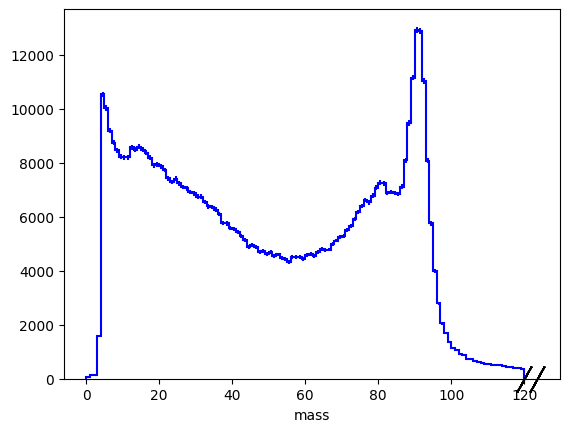

In [109]:
h1 = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
drawables = []

for elec in ur.iterate(
    # filename(s)
    ["data/ZZTo4e.root"],

    # branches to read as expressions
    ["Electron_pt", "Electron_eta", "Electron_phi", "Electron_charge"],

    # cut to apply to expressions
    cut="nElectron >= 2",

    # library dependent; for library="ak", try to split branch names at underscore and make nested records (poor man's NanoEvents)
    how="zip",

    # the all-important step_size!
    step_size="1 MB",

    # options you would normally pass to uproot.open
    xrootd_handler=ur.MultithreadedXRootDSource,
    num_workers=10,
):
    # do everything you're going to do to this array
    os_cut = elec[:, "Electron", "charge", 0] != elec[:, "Electron", "charge", 1]
    elec1 = elec[os_cut, 0, "Electron"]
    elec2 = elec[os_cut, 1, "Electron"]

    # such as filling a histogram
    h1.fill(np.sqrt(2*elec1.pt*elec2.pt*(np.cosh(elec1.eta - elec2.eta) - np.cos(elec1.phi - elec2.phi))))

    # a little magic to animate it; hardest part is removing the previous plots
    for drawable in drawables:
        drawable.stairs.remove()
        drawable.errorbar.remove()
        drawable.legend_artist.remove()
    drawables = h1.plot(color="blue")
    #plt.yscale("log")
    IPython.display.display(plb.gcf())
    IPython.display.clear_output(wait=True)

__Bing__: In the context of the Uproot library, ```num_workers``` is a parameter that can be used to *specify the number of worker processes to use when reading data from files*. This parameter is used in conjunction with the uproot.iterate and uproot.lazy functions, which allow you to read data from multiple files in parallel. When num_workers is set to a value greater than 1, Uproot will use multiple worker processes to read data from the files, which can improve performance when reading large amounts of data. The optimal value for num_workers depends on various factors such as the number of CPU cores available, the speed of the storage device, and the size of the data being read

### Lazy arrays

Lazy arrays were introduced so that you can explore a large dataset without knowing ahead of time what parts you're going to read.

In [110]:
lazytree = ur.lazy(["data/ZZTo4e.root"], step_size = "1mb")
lazytree

<Array [{run: 194533, ... MET_phi: -0.775}] type='1499093 * {"run": int32, "lumi...'>

In [111]:
lazytree.fields

['run',
 'luminosityBlock',
 'event',
 'PV_npvs',
 'PV_x',
 'PV_y',
 'PV_z',
 'nMuon',
 'Muon_pt',
 'Muon_eta',
 'Muon_phi',
 'Muon_mass',
 'Muon_charge',
 'Muon_pfRelIso03_all',
 'Muon_pfRelIso04_all',
 'Muon_dxy',
 'Muon_dxyErr',
 'Muon_dz',
 'Muon_dzErr',
 'nElectron',
 'Electron_pt',
 'Electron_eta',
 'Electron_phi',
 'Electron_mass',
 'Electron_charge',
 'Electron_pfRelIso03_all',
 'Electron_dxy',
 'Electron_dxyErr',
 'Electron_dz',
 'Electron_dzErr',
 'MET_pt',
 'MET_phi']

In [112]:
lazytree.type

1499093 * {"run": int32, "luminosityBlock": uint32, "event": uint64, "PV_npvs": int32, "PV_x": float32, "PV_y": float32, "PV_z": float32, "nMuon": uint32, "Muon_pt": var * float32, "Muon_eta": var * float32, "Muon_phi": var * float32, "Muon_mass": var * float32, "Muon_charge": var * int32, "Muon_pfRelIso03_all": var * float32, "Muon_pfRelIso04_all": var * float32, "Muon_dxy": var * float32, "Muon_dxyErr": var * float32, "Muon_dz": var * float32, "Muon_dzErr": var * float32, "nElectron": uint32, "Electron_pt": var * float32, "Electron_eta": var * float32, "Electron_phi": var * float32, "Electron_mass": var * float32, "Electron_charge": var * int32, "Electron_pfRelIso03_all": var * float32, "Electron_dxy": var * float32, "Electron_dxyErr": var * float32, "Electron_dz": var * float32, "Electron_dzErr": var * float32, "MET_pt": float32, "MET_phi": float32}

In [113]:
len(lazytree)

1499093

It _looks like_ we've read that big file.

But actually (if we peek in the lazy array's cache), we've only read 3 TBaskets.

In [114]:
lazytree._caches[0].keys()

['a641a30c-bebc-11eb-89ac-c4650d81beef:/Events;1:run(0):AsDtype(Bi4(),Li4()):0-9274:ak',
 'a641a30c-bebc-11eb-89ac-c4650d81beef:/Events;1:MET_phi(31):AsDtype(Bf4(),Lf4()):1493114-1499093:ak',
 'a641a30c-bebc-11eb-89ac-c4650d81beef:/Events;1:luminosityBlock(1):AsDtype(Bu4(),Lu4()):0-9274:ak']

```Big important warning: this access pattern is not read or memory efficient!```

### Writing histograms to root files

Has a simple key-value syntax.

In [115]:
print(uptree.keys())
a = uptree["E1"].array(library = "np")
h1 = hist.Hist.new.Reg(50,0,200).Double()
h1.fill(a)
b = uptree["E2"].array(library = "np")
h2 = hist.Hist.new.Reg(50,0,200).Double()
h2.fill(a)
h2

['Type', 'Run', 'Event', 'E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'M']


Hist(Regular(50, 0, 200, label='Axis 0'), storage=Double()) # Sum: 2297.0 (2304.0 with flow)

In [116]:
with ur.recreate("Histograms.root") as hfile :
    hfile["Energies/E1"] = h1
    hfile["Energies/E2"] = h2

In [117]:
w = ur.open("Histograms.root")
w.keys(cycle=False)

['Energies', 'Energies/E1', 'Energies/E2']

In [118]:
w["Energies/E1"]

<TH1D (version 3) at 0x7f53a7fbec80>

In [119]:
w["Energies/E1"].to_hist()

Hist(Regular(50, 0, 200, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=2297, variance=2297) (WeightedSum(value=2304, variance=2304) with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f53658eefe0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

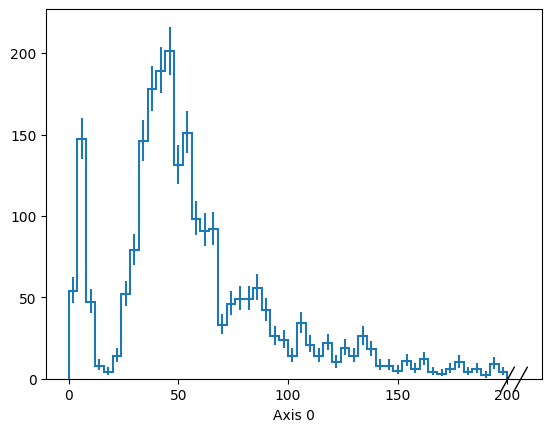

In [120]:
w["Energies/E1"].to_hist().plot()

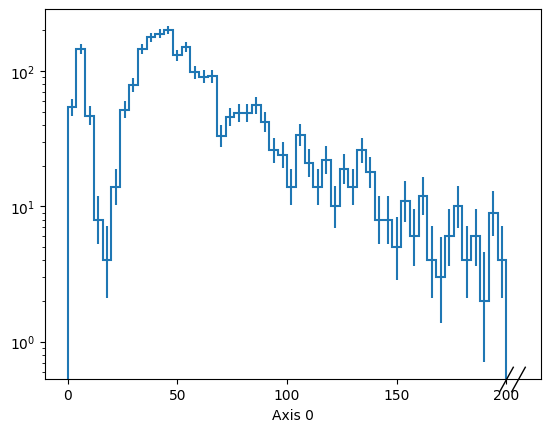

In [121]:
h = w["Energies/E1"].to_hist().plot()
plt.yscale("log")

### Writing TTrees to root files

In [122]:
tf = ur.recreate("tree.root")

mass = np.array([])
for index, elec in enumerate(ur.iterate(
    # filename(s)
    ["data/ZZTo4e.root"],

    # branches to read as expressions
    ["Electron_pt", "Electron_eta", "Electron_phi", "Electron_charge"],

    # cut to apply to expressions
    cut="nElectron >= 2",

    # library dependent; for library="ak", try to split branch names at underscore and make nested records (poor man's NanoEvents)
    how="zip",

    # the all-important step_size!
    step_size="1 MB",
    
    num_workers=10,
)):
    # do everything you're going to do to this array
    os_cut = elec[:, "Electron", "charge", 0] != elec[:, "Electron", "charge", 1]
    elec1 = elec[:, 0, "Electron"]
    elec2 = elec[:, 1, "Electron"]

    # calculation
    inv_mass = np.sqrt(2*elec1.pt*elec2.pt*(np.cosh(elec1.eta - elec2.eta) - np.cos(elec1.phi - elec2.phi)))
    mass = np.append( inv_mass, mass)
    cuts = os_cut & (inv_mass > 75)
    goodelec = elec[cuts].Electron
    goodelecmass =  inv_mass[cuts]
    #tree filling

    #first create a dictionary
    contents = {"goodelec": goodelec , "goodelecM": goodelecmass}

    # if this is the first write, assign directly
    if index == 0 :
        tf["ElectronCandidates"] = contents
    else :
        tf["ElectronCandidates"].extend(contents)
tf.close()

In [123]:
treefile = ur.open("tree.root")
treefile.classnames(cycle = False)

{'ElectronCandidates': 'TTree'}

In [124]:
uptree = treefile["ElectronCandidates"]
print(uptree.items())
treefile["ElectronCandidates"].show()

[('ngoodelec', <TBranch 'ngoodelec' at 0x7f5365786230>), ('goodelec_pt', <TBranch 'goodelec_pt' at 0x7f53657843d0>), ('goodelec_eta', <TBranch 'goodelec_eta' at 0x7f536566aaa0>), ('goodelec_phi', <TBranch 'goodelec_phi' at 0x7f536566a7d0>), ('goodelec_charge', <TBranch 'goodelec_charge' at 0x7f5365d65750>), ('goodelecM', <TBranch 'goodelecM' at 0x7f53657653f0>)]
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ngoodelec            | int32_t                  | AsDtype('>i4')
goodelec_pt          | float[]                  | AsJagged(AsDtype('>f4'))
goodelec_eta         | float[]                  | AsJagged(AsDtype('>f4'))
goodelec_phi         | float[]                  | AsJagged(AsDtype('>f4'))
goodelec_charge      | int32_t[]                | AsJagged(AsDtype('>i4'))
goodelecM            | float                    | AsDtype('>f4')


In [125]:
masses = uptree["goodelecM"]
a = masses.array(library = "np" )
a

array([95.44179 , 94.360855, 76.04877 , ..., 89.291595, 92.54402 ,
       93.61749 ], dtype=float32)

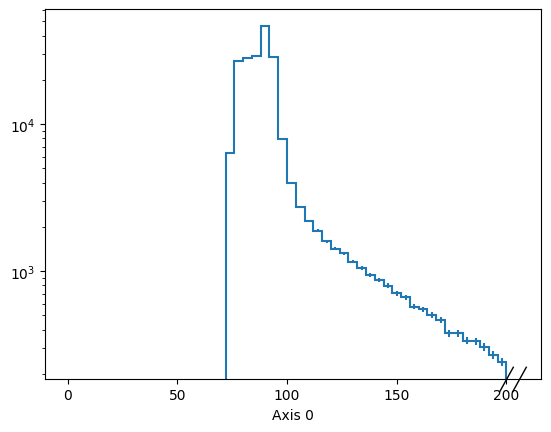

In [126]:
massplot =  hist.Hist.new.Reg(50,0,200).Double()
massplot.fill(a)
massplot.plot()
plt.yscale("log")

# Awkward Array

## General

In [127]:
events = ur.open("2022-08-01-uproot-awkward-columnar-hats/data/HZZ.root:events") #directly point to the tree
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
NJet                 | int32_t                  | AsDtype('>i4')
Jet_Px               | float[]                  | AsJagged(AsDtype('>f4'))
Jet_Py               | float[]                  | AsJagged(AsDtype('>f4'))
Jet_Pz               | float[]                  | AsJagged(AsDtype('>f4'))
Jet_E                | float[]                  | AsJagged(AsDtype('>f4'))
Jet_btag             | float[]                  | AsJagged(AsDtype('>f4'))
Jet_ID               | bool[]                   | AsJagged(AsDtype('bool'))
NMuon                | int32_t                  | AsDtype('>i4')
Muon_Px              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_Py              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_Pz              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_E               | float[]  

In [128]:
events["Muon_Px"].array()

<Array [[-52.9, 37.7], ... 1.14], [23.9]] type='2421 * var * float32'>

In [129]:
events["Muon_Px"].array(entry_stop = 20).to_list() #not recommended to convert to list

[[-52.89945602416992, 37.7377815246582],
 [-0.8164593577384949],
 [48.987831115722656, 0.8275666832923889],
 [22.08833122253418, 76.6919174194336],
 [45.171321868896484, 39.75095748901367],
 [9.228110313415527, -5.793715000152588],
 [12.538717269897461, 29.541839599609375],
 [34.883758544921875],
 [-53.16697311401367, 11.491869926452637],
 [-67.01485443115234, -18.118755340576172],
 [15.983028411865234, 34.68440628051758],
 [-70.51190948486328, -38.028743743896484],
 [58.94381332397461],
 [-15.587870597839355],
 [-122.33011627197266, -1.0597527027130127],
 [-46.70415496826172, 39.020023345947266],
 [51.29465866088867, 17.45092010498047],
 [43.28120040893555],
 [-45.92393493652344, 22.549766540527344],
 [43.29360580444336, -33.28158187866211, -4.376191139221191]]

NumPy's equivalent is cumbersome and inefficient

In [130]:
jagged_numpy = events["Muon_Px"].array(entry_stop = 20, library = "np")
jagged_numpy

array([array([-52.899456,  37.73778 ], dtype=float32),
       array([-0.81645936], dtype=float32),
       array([48.98783  ,  0.8275667], dtype=float32),
       array([22.088331, 76.69192 ], dtype=float32),
       array([45.17132 , 39.750957], dtype=float32),
       array([ 9.22811 , -5.793715], dtype=float32),
       array([12.538717, 29.54184 ], dtype=float32),
       array([34.88376], dtype=float32),
       array([-53.166973,  11.49187 ], dtype=float32),
       array([-67.014854, -18.118755], dtype=float32),
       array([15.983028, 34.684406], dtype=float32),
       array([-70.51191 , -38.028744], dtype=float32),
       array([58.943813], dtype=float32),
       array([-15.587871], dtype=float32),
       array([-122.33012  ,   -1.0597527], dtype=float32),
       array([-46.704155,  39.020023], dtype=float32),
       array([51.29466, 17.45092], dtype=float32),
       array([43.2812], dtype=float32),
       array([-45.923935,  22.549767], dtype=float32),
       array([ 43.293606, -33.

What if I want the first item in each list as an array?

In [131]:
np.array([x[0] for x in jagged_numpy]) #computationally poor since we are iterating here

array([ -52.899456  ,   -0.81645936,   48.98783   ,   22.088331  ,
         45.17132   ,    9.22811   ,   12.538717  ,   34.88376   ,
        -53.166973  ,  -67.014854  ,   15.983028  ,  -70.51191   ,
         58.943813  ,  -15.587871  , -122.33012   ,  -46.704155  ,
         51.29466   ,   43.2812    ,  -45.923935  ,   43.293606  ],
      dtype=float32)

In [132]:
jagged_numpy[:,0] #cant even slice since its a dtype = object

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Thats where awkward array helps us:

In [133]:
jagged_awkward = events["Muon_Px"].array(entry_stop = 20, library = "ak")
jagged_awkward

<Array [[-52.9, 37.7], ... 43.3, -33.3, -4.38]] type='20 * var * float32'>

In [134]:
LeadingMuons = jagged_awkward[:,0]
LeadingMuons

<Array [-52.9, -0.816, 49, ... -45.9, 43.3] type='20 * float32'>

In [135]:
LeadingMuons.to_numpy()

array([ -52.899456  ,   -0.81645936,   48.98783   ,   22.088331  ,
         45.17132   ,    9.22811   ,   12.538717  ,   34.88376   ,
        -53.166973  ,  -67.014854  ,   15.983028  ,  -70.51191   ,
         58.943813  ,  -15.587871  , -122.33012   ,  -46.704155  ,
         51.29466   ,   43.2812    ,  -45.923935  ,   43.293606  ],
      dtype=float32)

## Jaggedness in pandas

In [136]:
events.arrays(filter_name="Muon_*", library = "pd")

/home/prayag/.local/lib/python3.10/site-packages/uproot/interpretation/library.py:747: FutureWarning: MultiIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if hasattr(index, "is_integer") and index.is_integer():


Muon_Px    Muon_Py     Muon_Pz      Muon_E  Muon_Charge  \
entry subentry                                                              
0     0        -52.899456 -11.654672   -8.160793   54.779499            1   
      1         37.737782   0.693474  -11.307582   39.401695           -1   
1     0         -0.816459 -24.404259   20.199968   31.690445            1   
2     0         48.987831 -21.723139   11.168285   54.739788            1   
      1          0.827567  29.800508   36.965191   47.488857           -1   
...                   ...        ...         ...         ...          ...   
2416  0        -39.285824 -14.607491   61.715790   74.602982           -1   
2417  0         35.067146 -14.150043  160.817917  165.203949           -1   
2418  0        -29.756786 -15.303859  -52.663750   62.395161           -1   
2419  0          1.141870  63.609570  162.176315  174.208633           -1   
2420  0         23.913206 -35.665077   54.719437   69.556213           -1   

                Muon_Iso  
entry subentry            
0     0         4.200153  
      1         2.151061  
1     0         2.188047  
2     0         1.412822  
      1         3.383504  
...                  ...  
2416  0         1.080880  
2417  0         3.427752  
2418  0         3.762945  
2419  0         0.550811  
2420  0         0.000000  

[3825 rows x 6 columns]

This pandas dataframe is jagged and has entries and subentries

In [137]:
jagged_pandas = events.arrays(filter_name="/(Muon_|Jet_)*/", library = "pd")
len(jagged_pandas)

/home/prayag/.local/lib/python3.10/site-packages/uproot/interpretation/library.py:747: FutureWarning: MultiIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if hasattr(index, "is_integer") and index.is_integer():


4

In [138]:
jagged_pandas[0]

NJet     Jet_Px     Jet_Py      Jet_Pz       Jet_E  Jet_btag  \
entry subentry                                                                 
1     0            1 -38.874714  19.863453   -0.894942   44.137363      -1.0   
3     0            3 -71.695213  93.571579  196.296432  230.346008      -1.0   
      1            3  36.606369  21.838793   91.666283  101.358841      -1.0   
      2            3 -28.866419   9.320708   51.243221   60.084141      -1.0   
4     0            2   3.880162 -75.234055 -359.601624  367.585480      -1.0   
...              ...        ...        ...         ...         ...       ...   
2417  0            2 -33.196457 -59.664749  -29.040150   74.944725      -1.0   
      1            2 -26.086025 -19.068407   26.774284   42.481457      -1.0   
2418  0            1  -3.714818 -37.202377   41.012222   55.950581      -1.0   
2419  0            2 -36.361286  10.173571  226.429214  229.577988      -1.0   
      1            2 -15.256871 -27.175364   12.119683   33.920349      -1.0   

                Jet_ID  NMuon  NElectron  NPhoton  ...  MClepton_px  \
entry subentry                                     ...                
1     0           True      1          0        0  ...          0.0   
3     0           True      2          0        0  ...          0.0   
      1           True      2          0        0  ...          0.0   
      2           True      2          0        0  ...          0.0   
4     0           True      2          2        1  ...          0.0   
...                ...    ...        ...      ...  ...          ...   
2417  0           True      1          0        0  ...          0.0   
      1           True      1          0        0  ...          0.0   
2418  0           True      1          0        0  ...          0.0   
2419  0           True      1          0        1  ...          0.0   
      1           True      1          0        1  ...          0.0   

                MClepton_py  MClepton_pz  MCleptonPDGid  MCneutrino_px  \
entry subentry                                                           
1     0                 0.0          0.0              0            0.0   
3     0                 0.0          0.0              0            0.0   
      1                 0.0          0.0              0            0.0   
      2                 0.0          0.0              0            0.0   
4     0                 0.0          0.0              0            0.0   
...                     ...          ...            ...            ...   
2417  0                 0.0          0.0              0            0.0   
      1                 0.0          0.0              0            0.0   
2418  0                 0.0          0.0              0            0.0   
2419  0                 0.0          0.0              0            0.0   
      1                 0.0          0.0              0            0.0   

                MCneutrino_py  MCneutrino_pz  NPrimaryVertices  \
entry subentry                                                   
1     0                   0.0            0.0                18   
3     0                   0.0            0.0                 8   
      1                   0.0            0.0                 8   
      2                   0.0            0.0                 8   
4     0                   0.0            0.0                 2   
...                       ...            ...               ...   
2417  0                   0.0            0.0                18   
      1                   0.0            0.0                18   
2418  0                   0.0            0.0                 9   
2419  0                   0.0            0.0                 6   
      1                   0.0            0.0                 6   

                triggerIsoMu24  EventWeight  
entry subentry                               
1     0                   True     0.000331  
3     0                   True     0.007081  
      1                   True     0.007081  

In [139]:
jagged_pandas[1]

NJet  NMuon    Muon_Px    Muon_Py     Muon_Pz      Muon_E  \
entry subentry                                                              
0     0            0      2 -52.899456 -11.654672   -8.160793   54.779499   
      1            0      2  37.737782   0.693474  -11.307582   39.401695   
1     0            1      1  -0.816459 -24.404259   20.199968   31.690445   
2     0            0      2  48.987831 -21.723139   11.168285   54.739788   
      1            0      2   0.827567  29.800508   36.965191   47.488857   
...              ...    ...        ...        ...         ...         ...   
2416  0            1      1 -39.285824 -14.607491   61.715790   74.602982   
2417  0            2      1  35.067146 -14.150043  160.817917  165.203949   
2418  0            1      1 -29.756786 -15.303859  -52.663750   62.395161   
2419  0            2      1   1.141870  63.609570  162.176315  174.208633   
2420  0            0      1  23.913206 -35.665077   54.719437   69.556213   

                Muon_Charge  Muon_Iso  NElectron  NPhoton  ...  MClepton_px  \
entry subentry                                             ...                
0     0                   1  4.200153          0        0  ...          0.0   
      1                  -1  2.151061          0        0  ...          0.0   
1     0                   1  2.188047          0        0  ...          0.0   
2     0                   1  1.412822          0        0  ...          0.0   
      1                  -1  3.383504          0        0  ...          0.0   
...                     ...       ...        ...      ...  ...          ...   
2416  0                  -1  1.080880          0        0  ...          0.0   
2417  0                  -1  3.427752          0        0  ...          0.0   
2418  0                  -1  3.762945          0        0  ...          0.0   
2419  0                  -1  0.550811          0        1  ...          0.0   
2420  0                  -1  0.000000          0        1  ...          0.0   

                MClepton_py  MClepton_pz  MCleptonPDGid  MCneutrino_px  \
entry subentry                                                           
0     0                 0.0          0.0              0            0.0   
      1                 0.0          0.0              0            0.0   
1     0                 0.0          0.0              0            0.0   
2     0                 0.0          0.0              0            0.0   
      1                 0.0          0.0              0            0.0   
...                     ...          ...            ...            ...   
2416  0                 0.0          0.0              0            0.0   
2417  0                 0.0          0.0              0            0.0   
2418  0                 0.0          0.0              0            0.0   
2419  0                 0.0          0.0              0            0.0   
2420  0                 0.0          0.0              0            0.0   

                MCneutrino_py  MCneutrino_pz  NPrimaryVertices  \
entry subentry                                                   
0     0                   0.0            0.0                 6   
      1                   0.0            0.0                 6   
1     0                   0.0            0.0                18   
2     0                   0.0            0.0                16   
      1                   0.0            0.0                16   
...                       ...            ...               ...   
2416  0                   0.0            0.0                 9   
2417  0                   0.0            0.0                18   
2418  0                   0.0            0.0                 9   
2419  0                   0.0            0.0                 6   
2420  0                   0.0            0.0                12   

                triggerIsoMu24  EventWeight  
entry subentry                               
0     0                   True     0.009271  
      1                   

In [140]:
jagged_pandas[2]

NJet  NMuon  NElectron  Electron_Px  Electron_Py  Electron_Pz  \
entry subentry                                                                  
4     0            2      2          2   -82.592216    41.092983  -363.753113   
      1            2      2          2     4.162826   -23.218815   -66.383858   
15    0            0      2          1    13.831234     3.564487    56.735542   
114   0            1      2          1   -46.878876   -43.351032  -177.028412   
124   0            1      2          1   -36.483067   -13.627416   -37.939960   
...              ...    ...        ...          ...          ...          ...   
2361  0            0      2          2    -7.262786    54.933182   -20.446810   
      1            0      2          2    18.481556    33.376698     7.449298   
2389  0            1      2          1    -9.744128   -21.877804    34.970413   
2410  0            0      2          2   -37.681973     8.211936    -6.767756   
      1            0      2          2    18.453588    -4.034171    67.131828   

                Electron_E  Electron_Charge  Electron_Iso  NPhoton  ...  \
entry subentry                                                      ...   
4     0         375.268494               -1      1.090143        1  ...   
      1          70.450401                1      4.629203        1  ...   
15    0          58.505817                1      0.000000        1  ...   
114   0         188.191391               -1      2.455079        1  ...   
124   0          54.370590               -1      0.735831        2  ...   
...                    ...              ...           ...      ...  ...   
2361  0          59.063309               -1      0.657142        2  ...   
      1          38.872406                1      0.000000        2  ...   
2389  0          42.385330                1      0.207944        3  ...   
2410  0          39.155704               -1      3.369568        2  ...   
      1          69.738739                1      0.955300        2  ...   

                MClepton_px  MClepton_py  MClepton_pz  MCleptonPDGid  \
entry subentry                                                         
4     0                 0.0          0.0          0.0              0   
      1                 0.0          0.0          0.0              0   
15    0                 0.0          0.0          0.0              0   
114   0                 0.0          0.0          0.0              0   
124   0                 0.0          0.0          0.0              0   
...                     ...          ...          ...            ...   
2361  0                 0.0          0.0          0.0              0   
      1                 0.0          0.0          0.0              0   
2389  0                 0.0          0.0          0.0              0   
2410  0                 0.0          0.0          0.0              0   
      1                 0.0          0.0          0.0              0   

                MCneutrino_px  MCneutrino_py  MCneutrino_pz  NPrimaryVertices  \
entry subentry                                                                  
4     0                   0.0            0.0            0.0                 2   
      1                   0.0            0.0            0.0                 2   
15    0                   0.0            0.0            0.0                 3   
114   0                   0.0            0.0            0.0                 5   
124   0                   0.0            0.0            0.0                 8   
...                       ...            ...            ...               ...   
2361  0                   0.0            0.0            0.0                10   
      1                   0.0            0.0            0.0                10   
2389  0                   0.0            0.0            0.0                 3   
2410  0                   0.0            0.0            0.0                11   
      1                   0.0            0.0            0.0                11

In [141]:
jagged_pandas[3]

NJet  NMuon  NElectron  NPhoton  Photon_Px  Photon_Py  \
entry subentry                                                          
4     0            2      2          2        1 -93.808594  45.830330   
13    0            1      1          0        1 -14.844832  24.563778   
15    0            0      2          1        1  11.943524   2.626147   
64    0            4      2          0        1 -10.570637  13.571628   
114   0            1      2          1        1 -47.068924 -42.617908   
...              ...    ...        ...      ...        ...        ...   
2389  2            1      2          1        3   6.818264  14.046298   
2410  0            0      2          2        2 -39.131084   7.669469   
      1            0      2          2        2  19.779800  -4.877117   
2419  0            2      1          0        1 -29.460020   8.797814   
2420  0            0      1          0        1  -6.194361  16.441586   

                 Photon_Pz    Photon_E  Photon_Iso     MET_px  ...  \
entry subentry                                                 ...   
4     0        -412.850311  425.847229    0.921476   5.393139  ...   
13    0          63.007408   69.236420    0.875975  28.459160  ...   
15    0          48.938980   50.443714    1.151208   0.350357  ...   
64    0         -27.436132   32.383156    1.278783   2.110263  ...   
114   0        -177.187332  188.220947    1.134528  -5.053012  ...   
...                    ...         ...         ...        ...  ...   
2389  2           2.537921   15.818604    1.911849 -10.529509  ...   
2410  0          -7.123263   40.506832    3.287470 -25.754967  ...   
      1          72.441093   75.251167    1.465773 -25.754967  ...   
2419  0         189.465149  191.943573    1.594844  79.875191  ...   
2420  0          -2.490791   17.745419    4.733188  19.713749  ...   

                MClepton_px  MClepton_py  MClepton_pz  MCleptonPDGid  \
entry subentry                                                         
4     0                 0.0          0.0          0.0              0   
13    0                 0.0          0.0          0.0              0   
15    0                 0.0          0.0          0.0              0   
64    0                 0.0          0.0          0.0              0   
114   0                 0.0          0.0          0.0              0   
...                     ...          ...          ...            ...   
2389  2                 0.0          0.0          0.0              0   
2410  0                 0.0          0.0          0.0              0   
      1                 0.0          0.0          0.0              0   
2419  0                 0.0          0.0          0.0              0   
2420  0                 0.0          0.0          0.0              0   

                MCneutrino_px  MCneutrino_py  MCneutrino_pz  NPrimaryVertices  \
entry subentry                                                                  
4     0                   0.0            0.0            0.0                 2   
13    0                   0.0            0.0            0.0                 8   
15    0                   0.0            0.0            0.0                 3   
64    0                   0.0            0.0            0.0                 5   
114   0                   0.0            0.0            0.0                 5   
...                       ...            ...            ...               ...   
2389  2                   0.0            0.0            0.0                 3   
2410  0                   0.0            0.0            0.0                11   
      1                   0.0            0.0            0.0                11   
2419  0                   0.0            0.0            0.0                 6   
2420  0                   0.0            0.0            0.0                12   

                triggerIsoMu24  EventWeight  
entry subentry                               
4     0                   True     0.008536  
13    0                   

In Summary, crazy stuff happens when you want two types of objects like Muons and Electrons.
Morever, their lenths are very incompatible

Again, thats why awkward array comes into play.

In [142]:
array = events.arrays(filter_name="/(Muon_|Jet_).*/", library="ak", how="zip")
array

<Array [{Jet: [], Muon: [, ... Iso: 0}]}] type='2421 * {"Jet": var * {"Px": floa...'>

In [143]:
array.fields

['Jet', 'Muon']

In [144]:
array["Jet"]["ID"]

<Array [[], [True], [], ... [True, True], []] type='2421 * var * bool'>

In [145]:
array["Jet"]["ID"]

<Array [[], [True], [], ... [True, True], []] type='2421 * var * bool'>

In [146]:
ak.firsts(array.Jet) # First terms of every column

<Array [None, {Px: -38.9, ... ID: True}, None] type='2421 * ?{"Px": float32, "Py...'>

In [147]:
array.Jet.Px

<Array [[], [-38.9], ... [-36.4, -15.3], []] type='2421 * var * float32'>

In [148]:
array.Muon.Px

<Array [[-52.9, 37.7], ... 1.14], [23.9]] type='2421 * var * float32'>

In [149]:
ak.num(array.Jet) #returns array of the length of subarrays in array.Jet 

<Array [0, 1, 0, 3, 2, 2, ... 0, 1, 2, 1, 2, 0] type='2421 * int64'>

## More Stuff

Why is awkward array more efficient?
- Slicing throught data is more computationally inexpensive than modifying any large buffers over and over again.

- can use numpy-like idioms on json-like data structure(dictionary/hash-map)

- Numpy-like functional broadcasting operations(ufuncs) are valid in awkward array

### Slicing

In [150]:
array = events.arrays()
array

<Array [{NJet: 0, ... EventWeight: 0.00876}] type='2421 * {"NJet": int32, "Jet_P...'>

In [151]:
array.fields

['NJet',
 'Jet_Px',
 'Jet_Py',
 'Jet_Pz',
 'Jet_E',
 'Jet_btag',
 'Jet_ID',
 'NMuon',
 'Muon_Px',
 'Muon_Py',
 'Muon_Pz',
 'Muon_E',
 'Muon_Charge',
 'Muon_Iso',
 'NElectron',
 'Electron_Px',
 'Electron_Py',
 'Electron_Pz',
 'Electron_E',
 'Electron_Charge',
 'Electron_Iso',
 'NPhoton',
 'Photon_Px',
 'Photon_Py',
 'Photon_Pz',
 'Photon_E',
 'Photon_Iso',
 'MET_px',
 'MET_py',
 'MChadronicBottom_px',
 'MChadronicBottom_py',
 'MChadronicBottom_pz',
 'MCleptonicBottom_px',
 'MCleptonicBottom_py',
 'MCleptonicBottom_pz',
 'MChadronicWDecayQuark_px',
 'MChadronicWDecayQuark_py',
 'MChadronicWDecayQuark_pz',
 'MChadronicWDecayQuarkBar_px',
 'MChadronicWDecayQuarkBar_py',
 'MChadronicWDecayQuarkBar_pz',
 'MClepton_px',
 'MClepton_py',
 'MClepton_pz',
 'MCleptonPDGid',
 'MCneutrino_px',
 'MCneutrino_py',
 'MCneutrino_pz',
 'NPrimaryVertices',
 'triggerIsoMu24',
 'EventWeight']

In [152]:
array.Muon_Px #Just pointing to the data, hence almost zro cost

<Array [[-52.9, 37.7], ... 1.14], [23.9]] type='2421 * var * float32'>

In [153]:
ak.zip({"px": array.Muon_Px,"py": array.Muon_Py,"pz": array.Muon_Pz}) #also inexpensive

<Array [[{px: -52.9, py: -11.7, ... pz: 54.7}]] type='2421 * var * {"px": float3...'>

In [155]:
np.sqrt(array.Muon_Px**2 + array.Muon_Py**2) #returns an awkward array

<Array [[54.2, 37.7], [24.4, ... 63.6], [42.9]] type='2421 * var * float32'>

### Cartesian and Combinatorial products

<br><br><br>

And there are specialized operations that only make sense in a variable-length context.

<table style="margin-left: 0px">
    <tr style="background: white"><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html">ak.cartesian</a></td><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html">ak.combinations</a></td></tr>
    <tr style="background: white"><td><img src="2022-08-01-uproot-awkward-columnar-hats/img/cartoon-cartesian.png"></td><td><img src="2022-08-01-uproot-awkward-columnar-hats/img/cartoon-combinations.png"></td></tr>
</table>

In [166]:
ak.num(array.Muon_Px) #depth by default is one

<Array [2, 1, 2, 2, 2, 2, ... 2, 1, 1, 1, 1, 1] type='2421 * int64'>

In [167]:
ak.num(array.Jet_Px) #depth by default is one

<Array [0, 1, 0, 3, 2, 2, ... 0, 1, 2, 1, 2, 0] type='2421 * int64'>

In [168]:
cart = ak.cartesian((array.Muon_Px , array.Jet_Px))
cart

<Array [[], [(-0.816, -38.9, ... -15.3)], []] type='2421 * var * (float32, float32)'>

In [169]:
ak.num(cart)

<Array [0, 1, 0, 6, 4, 4, ... 0, 1, 2, 1, 2, 0] type='2421 * int64'>

In [173]:
comb = ak.combinations(array.Muon_Px,2)
comb

<Array [[(-52.9, 37.7)], [], ... [], [], []] type='2421 * var * (float32, float32)'>

In [174]:
ak.num(comb)

<Array [1, 0, 1, 1, 1, 1, ... 1, 0, 0, 0, 0, 0] type='2421 * int64'>

- Awkward Arrays can also have custom behaviour. For example it can utilise functions and routines of the vector class
- The vector class is similar to the TLorentzVector class in in Root.

In [176]:
import vector
vector.register_awkward()

In [178]:
muons = ak.zip({"px":array.Muon_Px, "py":array.Muon_Py, "pz":array.Muon_Pz, "E":array.Muon_E }, with_name="Momentum4D") #Creates the special momentum 4D object Awkward array
muons

<MomentumArray4D [[{px: -52.9, py: -11.7, ... E: 69.6}]] type='2421 * var * Mome...'>

In [181]:
muons.pt

<Array [[54.2, 37.7], [24.4, ... 63.6], [42.9]] type='2421 * var * float32'>

In [182]:
muons.eta

<Array [[-0.15, -0.295], ... 1.67], [1.06]] type='2421 * var * float32'>

In [183]:
muons.phi

<Array [[-2.92, 0.0184], ... 1.55], [-0.98]] type='2421 * var * float32'>

<u><b> Example of using cartesian products : <b><u>

Finding $ \Delta R $ of Jets and Muons

In [184]:
jets = ak.zip({"px":array.Jet_Px, "py": array.Jet_Py, "pz":array.Jet_Pz, "E":array.Jet_E},with_name="Momentum4D")
jets

<MomentumArray4D [[], [{px: -38.9, ... E: 33.9}], []] type='2421 * var * Momentu...'>

In [196]:
print(muons[1])
print(jets[1])

[{px: -0.816, py: -24.4, pz: 20.2, E: 31.7}]
[{px: -38.9, py: 19.9, pz: -0.895, E: 44.1}]


In [187]:
cart = ak.cartesian((muons,jets))
cart

<Array [[], [({px: -0.816, ... E: 33.9})], []] type='2421 * var * (Momentum4D["p...'>

In [208]:
print(cart[1])
print(cart[1][0]) # only one possible product here
a, b = cart[1][0]

[... py: -24.4, pz: 20.2, E: 31.7}, {px: -38.9, py: 19.9, pz: -0.895, E: 44.1})]
... py: -24.4, pz: 20.2, E: 31.7}, {px: -38.9, py: 19.9, pz: -0.895, E: 44.1})


In [188]:
ak.unzip(cart)

(<MomentumArray4D [[], [{px: -0.816, ... E: 174}], []] type='2421 * var * Momentu...'>,
 <MomentumArray4D [[], [{px: -38.9, ... E: 33.9}], []] type='2421 * var * Momentu...'>)

In [189]:
ms , js = ak.unzip(cart)

In [190]:
ms

<MomentumArray4D [[], [{px: -0.816, ... E: 174}], []] type='2421 * var * Momentu...'>

In [191]:
js

<MomentumArray4D [[], [{px: -38.9, ... E: 33.9}], []] type='2421 * var * Momentu...'>

In [209]:
ms.deltaR(js)

<Array [[], [2.15], [], ... [1.55, 2.94], []] type='2421 * var * float32'>

<u><b> Example of using Combination products : <b><u>

Muon Pairs:

In [210]:
ak.num(muons)

<Array [2, 1, 2, 2, 2, 2, ... 2, 1, 1, 1, 1, 1] type='2421 * int64'>

In [211]:
m1, m2 = ak.unzip(ak.combinations(muons, 2))

In [212]:
m1

<MomentumArray4D [[{px: -52.9, py: -11.7, ... [], []] type='2421 * var * Momentu...'>

In [213]:
ak.num(m1)

<Array [1, 0, 1, 1, 1, 1, ... 1, 0, 0, 0, 0, 0] type='2421 * int64'>

In [214]:
m2

<MomentumArray4D [[{px: 37.7, py: 0.693, ... [], []] type='2421 * var * Momentum...'>

In [215]:
ak.num(m2)

<Array [1, 0, 1, 1, 1, 1, ... 1, 0, 0, 0, 0, 0] type='2421 * int64'>

In [217]:
m = (m1+m2).mass
m

<Array [[90.2], [], [74.7], ... [], [], [], []] type='2421 * var * float32'>

In [219]:
flattened_mass = ak.flatten(m) # creates a oneD array
flattened_mass

<Array [90.2, 74.7, 89.8, ... 92.1, 85.4, 76] type='1521 * float32'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f5363e43850>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

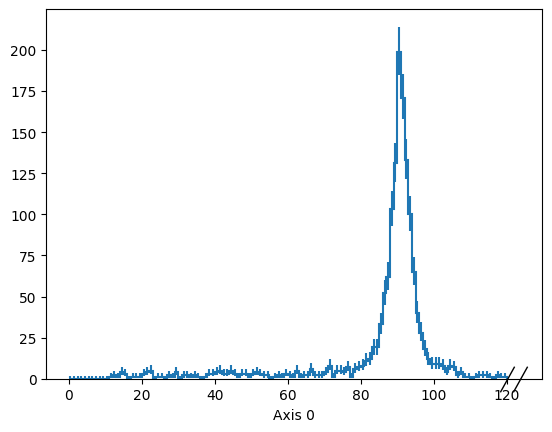

In [224]:
import hist
h =hist.Hist.new.Reg(120,0,120).Double()
h.fill(flattened_mass)
h.plot()

<iframe scrolling="no"  src="https://videos.cern.ch/video/OPEN-VIDEO-2022-236-004" width="560" height="315" frameborder="0" allowfullscreen></iframe>

### The Particle Library

In [289]:
import particle

Particle library has lookup data for particle masses and similar things

In [290]:
particle.Particle.from_evtgen_name("e-")

<Particle: name="e-", pdgid=11, mass=0.51099895000 ± 0.00000000015 MeV>

In [291]:
particle.Particle.from_evtgen_name("e-").mass #mass in MeV

0.51099895

In [292]:
repr(particle.Particle.from_evtgen_name("e-"))

'<Particle: name="e-", pdgid=11, mass=0.51099895000 ± 0.00000000015 MeV>'

In [293]:
event = ur.open("data/ZZTo4e.root:Events")
event.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

In [294]:
arr = event.arrays(["Electron_pt", "Electron_eta", "Electron_phi","Electron_charge"],entry_stop = 1000000)
arr

<Array [{Electron_pt: [11.9, 26.7, ... 1, -1]}] type='1000000 * {"Electron_pt": ...'>

In [295]:
arr.fields

['Electron_pt', 'Electron_eta', 'Electron_phi', 'Electron_charge']

In [296]:
elec2 = ak.zip({ "pt" : arr.Electron_pt , "eta" : arr.Electron_eta , "phi" : arr.Electron_phi , "q" : arr.Electron_charge }, with_name="Momentum4D")
elec2["mass"] = particle.Particle.from_evtgen_name("e-").mass / 1000.0
elec2.fields

['pt', 'eta', 'phi', 'q', 'mass']

In [297]:
elec2.px

<Array [[-6.52, -8.79, 16.3, ... 28.4, -33]] type='1000000 * var * float32'>

In [298]:
elec2.py

<Array [[-9.91, -25.2, 36.7, ... -16.9, 2.42]] type='1000000 * var * float32'>

In [299]:
elec2.pz

<Array [[4.05, 50.8, 15.6, ... 36, -44.8]] type='1000000 * var * float32'>

In [300]:
elec2.E

<Array [[12.5, 57.4, 43.1, ... 48.9, 55.7]] type='1000000 * var * float64'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f532867d480>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

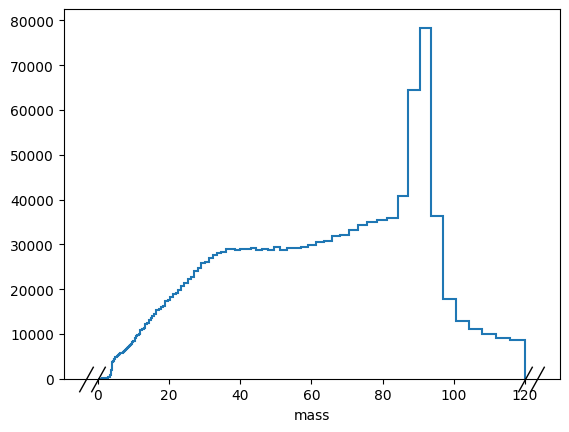

In [301]:
e1, e2 = ak.unzip(ak.combinations(elec2, 2))
hist.Hist.new.Log(200, 0.1, 120, name="mass").Double().fill(
    ak.flatten((e1 + e2).mass)
).plot()

## Awkward Arrays and Vector in Numba

Sometimes when the length of arrays are large, doing a cartesian or combination operation maybe very resource intensive.

In such cases , using simple loops in numba is fruitful

In [303]:
import numba as nb

In [307]:
@nb.njit #the decorator
def first_big_dielectron(events):
    for event in events:
        for i in range(len(event)):
            elec1 = event[i]
            for j in range(i + 1, len(event)):
                elec2 = event[j]
                dielectron = elec1 + elec2
                if dielectron.mass > 10:
                    return dielectron

Note here that it was assumed here that muons are sorted by pt.

In [308]:
first_big_dielectron(elec2)

MomentumObject4D(pt=38.32635498046875, phi=-1.981710433959961, eta=1.155301570892334, mass=20.298318836302432)

In [309]:
first_big_dielectron(elec2)

MomentumObject4D(pt=38.32635498046875, phi=-1.981710433959961, eta=1.155301570892334, mass=20.298318836302432)

## Sorting

In [314]:
elec2.pt

<Array [[11.9, 26.7, 40.2, ... 59.4, 33, 33.1]] type='1000000 * var * float32'>

In [316]:
elec2[-1].pt

<Array [52.3, 59.4, 33, 33.1] type='4 * float32'>

In [330]:
elec_sorted = ak.sort(elec2.pt, ascending = False) # by default depth is -1 i.e. axis= -1
elec_sorted

<Array [[40.2, 26.7, 11.9, ... 52.3, 33.1, 33]] type='1000000 * var * float32'>

In [331]:
elec_sorted[-1]

<Array [59.4, 52.3, 33.1, 33] type='4 * float32'>

In [332]:
elec_argsorted = ak.argsort(elec2.pt, ascending = False) # same sort but gives back the indices of the sorted data
elec_argsorted

<Array [[0, 1, 2], [0, 1, ... 3], [0, 1, 2, 3]] type='1000000 * var * int64'>

In [333]:
elec_argsorted[-1]

<Array [0, 1, 2, 3] type='4 * int64'>

In [334]:
#To sort the record on the go:
elec2 = elec2[ak.argsort(elec2.pt , ascending = False)]

In [335]:
elec2[-1].pt

<Array [59.4, 52.3, 33.1, 33] type='4 * float32'>

## Packing

Packing reduces the mempry utilisation after cuts are made to an awkaward array

```layout``` tells you the way the data is stored in the memory spaces.

In [336]:
elec2.layout

<ListOffsetArray64>
    <offsets><Index64 i="[0 3 7 9 10 10 13 16 19 23 ... 2034670 2034671 2034675 2034678 2034682 2034684 2034686 2034686 2034690 2034694]" offset="0" length="1000001" at="0x5564b19755b0"/></offsets>
    <content><IndexedArray64>
        <index><Index64 i="[2 1 0 6 3 4 5 8 7 9 ... 2034684 2034685 2034689 2034687 2034686 2034688 2034691 2034690 2034693 2034692]" offset="0" length="2034694" at="0x5564b5f506d0"/></index>
        <content><RecordArray length="2034694">
            <parameters>
                <param key="__record__">"Momentum4D"</param>
            </parameters>
            <field index="0" key="pt">
                <NumpyArray format="f" shape="2034694" data="11.8588 26.7161 40.1922 18.5107 14.7805 ... 45.5906 52.2773 59.3687 33.0211 33.0821" at="0x5564a8f98be0"/>
            </field>
            <field index="1" key="eta">
                <NumpyArray format="f" shape="2034694" data="0.335077 1.39797 0.379066 0.847147 1.02088 ... -0.976632 -0.184881 0.63

In [339]:
elec2[elec2.pt > 50].layout # reduces the actual data

<ListOffsetArray64>
    <offsets><Index64 i="[0 0 0 0 0 0 0 1 1 1 ... 228822 228822 228822 228822 228824 228824 228824 228824 228824 228826]" offset="0" length="1000001" at="0x5564b7677920"/></offsets>
    <content><IndexedArray64>
        <index><Index64 i="[14 28 29 46 45 70 71 68 74 84 ... 2034633 2034634 2034642 2034653 2034661 2034663 2034681 2034680 2034691 2034690]" offset="0" length="228826" at="0x5564a55e5710"/></index>
        <content><RecordArray length="2034694">
            <parameters>
                <param key="__record__">"Momentum4D"</param>
            </parameters>
            <field index="0" key="pt">
                <NumpyArray format="f" shape="2034694" data="11.8588 26.7161 40.1922 18.5107 14.7805 ... 45.5906 52.2773 59.3687 33.0211 33.0821" at="0x5564a8f98be0"/>
            </field>
            <field index="1" key="eta">
                <NumpyArray format="f" shape="2034694" data="0.335077 1.39797 0.379066 0.847147 1.02088 ... -0.976632 -0.184881 0.637598 0.

In [340]:
ak.packed(elec2[elec2.pt > 50]).layout

<ListOffsetArray64>
    <offsets><Index64 i="[0 0 0 0 0 0 0 1 1 1 ... 228822 228822 228822 228822 228824 228824 228824 228824 228824 228826]" offset="0" length="1000001" at="0x5564b7e18b30"/></offsets>
    <content><RecordArray length="228826">
        <parameters>
            <param key="__record__">"Momentum4D"</param>
        </parameters>
        <field index="0" key="pt">
            <NumpyArray format="f" shape="228826" data="54.6866 92.2721 80.6875 78.5311 65.0717 ... 53.7077 69.2535 62.2191 59.3687 52.2773" at="0x5564a5426830"/>
        </field>
        <field index="1" key="eta">
            <NumpyArray format="f" shape="228826" data="-0.420438 0.320591 0.334485 -1.20236 0.0759631 ... -0.716254 0.257818 -2.06126 0.637598 -0.184881" at="0x5564a5505fa0"/>
        </field>
        <field index="2" key="phi">
            <NumpyArray format="f" shape="228826" data="-0.0629134 -1.77349 -0.616533 -0.405206 2.07057 ... -2.6275 -1.90222 0.969917 2.26935 -0.732659" at="0x55649ebae100"/>